In [ ]:
# adapted from https://stmorse.github.io/journal/spotify-api.html and 
# https://github.com/ZipBomb/spotify-song-suggestion/blob/master/random_song.py
# popularity from Nov 23, 2020

In [20]:
import base64
import json
import random
import urllib
import requests
from tqdm import tqdm
import pandas as pd

CLIENT_ID = '6480491e23264b429963178e13b36b1e'
CLIENT_SECRET = 'cbd284788bf846b6bf7fd2b870fa1da5'

# Spotify API URIs
# words_txt = pd.read_csv('word_list.txt',header=None)
# word_list = words_txt[0].to_list()

AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

headers = {
'Authorization': 'Bearer {token}'.format(token=access_token)
}

BASE_URL = 'https://api.spotify.com/v1/'

In [21]:
def get_song(number):
    
    #input: number of songs requestes
    #output: df with track name and id, artist name and search term
    
    song_df = pd.DataFrame(columns=['track','artist','id','search term'])
    songs = 0
    pbar = tqdm(total=number,position=0, leave=True)
    
    while songs < number:
    
        # search term for random search
        search_term = random.choice(word_list)
        
        song_id = None
        

        # Cap the max number of requests
        for i in range(10):
            try:
                song_request = requests.get(
                    '{}search?q={}&type=track&offset={}'.format(
                        BASE_URL,
                        search_term,
                        random.randint(0, 200)
                    ),
                    headers = headers
                )
                song_info = random.choice(json.loads(song_request.text)['tracks']['items'])
                artist = song_info['artists'][0]['name']
                song = song_info['name']
                song_id = song_info['id']
                break
            except: #not all words will bring up a song
                continue
                
        if song_id: #only append valid songs
            song_to_append = pd.DataFrame([[song,artist,song_id,search_term]],columns=['track','artist','id',
                                                                                   'search term'])
            song_df = song_df.append(song_to_append,ignore_index = True)
            songs+=1
            pbar.update(1)
            
    pbar.close()
    return song_df

In [22]:
def get_traits(df):
    #input: df with song ids in column 'id'
    #output: df with track audio features 
    
    attr_df = pd.DataFrame(columns=['artist','track','id','danceability','energy','key','loudness','mode',
                                           'speechiness','acousticness','instrumentalness','liveness',
                                           'valence','tempo','duration_ms'])
    pbar = tqdm(total=len(df['id']),position=0, leave=True)
        
    error_ls = []
    for i in range(len(df['id'])): 
        try:
            track_id = df['id'][i]
            r = requests.get(BASE_URL + 'audio-features/' + track_id, headers=headers)
            r = r.json()

            attr_to_append = pd.DataFrame([[df['artist'][i],df['track'][i],df['id'][i], r['danceability'],r['energy'], 
                                          r['key'],r['loudness'],r['mode'], r['speechiness'],r['acousticness'],
                                          r['instrumentalness'],r['liveness'],r['valence'],r['tempo'],
                                            r['duration_ms']]],columns=['artist','track','id','danceability',
                                                                        'energy','key','loudness','mode',
                                                                        'speechiness','acousticness',
                                                                        'instrumentalness','liveness','valence',
                                                                        'tempo','duration_ms'])
            
            attr_df = attr_df.append(attr_to_append,ignore_index = True)
            pbar.update(1)
        
        except:
            error_ls.append(df['id'][i])
            pbar.update(1)
            continue 
        
    pbar.close()
    return attr_df, error_ls

In [23]:
def get_tracks_info(df):
    
    #input: df with song ids in column 'id'
    #output: df with track popularity, artist and album info
    
    attr_df = pd.DataFrame(columns=['id','popularity', 'artist dict', 'album blob'])
    pbar = tqdm(total=len(df['id']),position=0, leave=True)
    error_ls = []

    for i in range(len(df['id'])): 
        try:
            track_id = df['id'][i]
            r = requests.get(BASE_URL + 'tracks/' + track_id, headers=headers)
            r = r.json()

            attr_to_append = pd.DataFrame([[df['id'][i], r['popularity'],r['artists'],r['album']]],
                                          columns=['id','popularity', 'artist dict', 'album blob'])
            attr_df = attr_df.append(attr_to_append,ignore_index = True)
            pbar.update(1)
        
        except:
            error_ls.append(df['id'][i])
            pbar.update(1)
            continue 
        
    pbar.close()
    return attr_df, error_ls

In [24]:
def format_artist(df):
    
    #input: df with artist dict and song id 
    #output: df with list of names and ids for each artist on a track
    
    attr_df = pd.DataFrame(columns=['id','artist name ls','artist id ls'])
    
    for i in range(len(df['artist dict'])): 
        
        artist_dict = df['artist dict'][i]
        artist_ids = []
        artist_names = []
        
        for d in range(len(artist_dict)):
            artist_ids.append(artist_dict[d]['id'])
            artist_names.append(artist_dict[d]['name'])
        
        attr_to_append = pd.DataFrame([[df['id'][i], artist_names, artist_ids]], 
                                      columns=['id','artist name ls', 'artist id ls'])  
        attr_df = attr_df.append(attr_to_append,ignore_index = True)
    
       
    return attr_df

In [25]:
def get_artist_info(df):
    
    #request artist popularity from API
    #input: df with list of artist ids
    #output: list of artist popularity scores
    
    attr_df = pd.DataFrame(columns=['id','artist popularity'])
    num_artists = 0
    
    for i in range(len(df['artist name ls'])):
        num_artists += len(df['artist name ls'][i])
        
    pbar = tqdm(total=num_artists-1,position=0, leave=True)
    error_ls = []

    for i in range(len(df['artist id ls'])):
        artist_ls = df['artist id ls'][i]
        popularity = []
    
        for a in range(len(artist_ls)):
            try:
                artist_id = artist_ls[a]
                r = requests.get(BASE_URL + 'artists/' + artist_id, headers=headers)
                r = r.json()
                popularity.append(r['popularity'])
                pbar.update(1)

            except:
                error_ls.append(df['id'][i])
                pbar.update(1)
                continue 
        attr_to_append = pd.DataFrame([[df['id'][i], popularity]], columns=['id','artist popularity'])
        attr_df = attr_df.append(attr_to_append,ignore_index = True)
            
    return attr_df, error_ls

In [7]:
def get_release(blob):
    #extract release date
    return blob['release_date']

In [16]:
# songs = get_song(10000)
songs = pd.read_csv('songsnov23.csv', index_col = 0)
songs
traits = pd.read_csv('traitsnov23.csv', index_col = 0)
songs

,track,artist,id,search term
0,My Cousin Harris,Aziz Ansari,0ojSU3QoovuJxwVYk34opc,intimate
1,"Before She Does - Live At Target Center, Minne...",Eric Church,42ToYHW2koZnAqgDoEQ314,minneapolis
2,Muerto en Choroni,Selected Music,1nfbOAPwnMRBlE0rUNGg43,selected
3,Unwind in the Tropics,Relaxmycat,4iuthceAzx9jJt5o08HwMb,resting
4,Waiver,Reki,7l1B4m3ujaWim9n3zMMhwa,waive
...,...,...,...,...
9995,Shining Clothing,El Vergaras,43LE7GvHXTFE8aUKX3qZr6,clothing
9996,Woodlands,BITWVLF,7oPl7r8kLdjpeXlWg7LDc1,woodlands
9997,Jumpin' Jack Flash,Los Colognes,04rMosX7Wp0gVhUPcJEPQr,cologne
9998,Grades Scrubstone,Atomic Convinced,0MtUy6AgMuIVmteyZtehrz,convince


In [25]:
both = pd.merge(songs,traits,on = ['id','track','artist'], how='left')
both

,track,artist,id,search term,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,My Cousin Harris,Aziz Ansari,0ojSU3QoovuJxwVYk34opc,intimate,0.657,0.6220,3.0,-7.026,1.0,0.9440,0.8040,0.00000,0.9170,0.3950,66.521,96053.0
1,"Before She Does - Live At Target Center, Minne...",Eric Church,42ToYHW2koZnAqgDoEQ314,minneapolis,0.504,0.7770,0.0,-8.583,1.0,0.0370,0.0648,0.00001,0.8030,0.3560,104.023,209277.0
2,Muerto en Choroni,Selected Music,1nfbOAPwnMRBlE0rUNGg43,selected,0.726,0.9150,4.0,-5.407,0.0,0.2300,0.0351,0.00000,0.2830,0.8370,127.994,246826.0
3,Unwind in the Tropics,Relaxmycat,4iuthceAzx9jJt5o08HwMb,resting,0.204,0.0423,6.0,-26.704,1.0,0.0517,0.9930,0.82700,0.1120,0.0345,89.789,112000.0
4,Waiver,Reki,7l1B4m3ujaWim9n3zMMhwa,waive,0.419,0.6690,0.0,-8.137,0.0,0.0377,0.5070,0.34800,0.1150,0.0382,94.837,252682.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10069,Shining Clothing,El Vergaras,43LE7GvHXTFE8aUKX3qZr6,clothing,0.268,0.1170,0.0,-15.616,1.0,0.0367,0.2440,0.08250,0.1520,0.0400,139.678,207479.0
10070,Woodlands,BITWVLF,7oPl7r8kLdjpeXlWg7LDc1,woodlands,0.655,0.6660,3.0,-9.673,0.0,0.0345,0.0494,0.91100,0.0959,0.1900,129.995,176135.0
10071,Jumpin' Jack Flash,Los Colognes,04rMosX7Wp0gVhUPcJEPQr,cologne,0.554,0.7530,0.0,-7.088,1.0,0.0334,0.5090,0.00137,0.1950,0.5960,126.818,255987.0
10072,Grades Scrubstone,Atomic Convinced,0MtUy6AgMuIVmteyZtehrz,convince,0.198,0.0282,0.0,-23.294,0.0,0.0384,0.9950,0.93300,0.1030,0.0390,86.697,102008.0


In [32]:
both = both.drop_duplicates()

In [35]:
info, info_err = get_tracks_info(songs)
len(info_err)

100%|██████████| 10000/10000 [18:55<00:00,  8.80it/s]


0

In [39]:
artists_format = format_artist(info)

In [62]:
artist_pop, err_artist_pop = get_artist_info(artist_format)
len(err_artist_pop)

55

In [67]:
info['album blob'] = info['album blob'].apply(get_release)

In [71]:
info.drop(columns=['artist dict'], inplace = True)

In [123]:
info.rename(columns = {'album blob':'release date'}, inplace=True)

In [82]:
artist_pop.head()

,id,artist popularity
0,0ojSU3QoovuJxwVYk34opc,[49]
1,42ToYHW2koZnAqgDoEQ314,[77]
2,1nfbOAPwnMRBlE0rUNGg43,"[30, 26, 53, 57]"
3,4iuthceAzx9jJt5o08HwMb,"[53, 27, 33]"
4,7l1B4m3ujaWim9n3zMMhwa,[25]


In [75]:
both.head()

,track,artist,id,search term,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,My Cousin Harris,Aziz Ansari,0ojSU3QoovuJxwVYk34opc,intimate,0.657,0.6220,3.0,-7.026,1.0,0.9440,0.8040,0.00000,0.917,0.3950,66.521,96053.0
1,"Before She Does - Live At Target Center, Minne...",Eric Church,42ToYHW2koZnAqgDoEQ314,minneapolis,0.504,0.7770,0.0,-8.583,1.0,0.0370,0.0648,0.00001,0.803,0.3560,104.023,209277.0
2,Muerto en Choroni,Selected Music,1nfbOAPwnMRBlE0rUNGg43,selected,0.726,0.9150,4.0,-5.407,0.0,0.2300,0.0351,0.00000,0.283,0.8370,127.994,246826.0
3,Unwind in the Tropics,Relaxmycat,4iuthceAzx9jJt5o08HwMb,resting,0.204,0.0423,6.0,-26.704,1.0,0.0517,0.9930,0.82700,0.112,0.0345,89.789,112000.0
4,Waiver,Reki,7l1B4m3ujaWim9n3zMMhwa,waive,0.419,0.6690,0.0,-8.137,0.0,0.0377,0.5070,0.34800,0.115,0.0382,94.837,252682.0


In [114]:
all_popularity = pd.merge(info,artist_pop,left_on = 'id', right_on = 'id')
all_popularity.drop_duplicates(subset='id')

,id,popularity,release date,artist popularity
0,0ojSU3QoovuJxwVYk34opc,35,2010-01-18,[49]
1,42ToYHW2koZnAqgDoEQ314,27,2019-05-24,[77]
2,1nfbOAPwnMRBlE0rUNGg43,20,2020-08-28,"[30, 26, 53, 57]"
3,4iuthceAzx9jJt5o08HwMb,0,2020-11-18,"[53, 27, 33]"
4,7l1B4m3ujaWim9n3zMMhwa,4,2012-06-15,[25]
...,...,...,...,...
10069,43LE7GvHXTFE8aUKX3qZr6,26,2017-08-01,[29]
10070,7oPl7r8kLdjpeXlWg7LDc1,12,2018-04-25,[25]
10071,04rMosX7Wp0gVhUPcJEPQr,30,2016-02-17,[28]
10072,0MtUy6AgMuIVmteyZtehrz,14,2020-10-11,[23]


In [126]:
all_data = pd.merge(both,all_popularity,left_on = 'id', right_on = 'id')

In [127]:
#duplicates need to be dropped as sometimes the same song was selected with two different keywords (37 songs)
#example below
songs[songs['id']=='1r453bo3yToA356T5H0LoP']

,track,artist,id,search term
51,Watching The Detectives,Elvis Costello,1r453bo3yToA356T5H0LoP,detective
787,Watching The Detectives,Elvis Costello,1r453bo3yToA356T5H0LoP,watching


In [124]:
all_data.drop_duplicates(subset=['id'], inplace=True)
all_data

,track,artist,id,search term,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity,release date,artist popularity
0,My Cousin Harris,Aziz Ansari,0ojSU3QoovuJxwVYk34opc,intimate,0.657,0.6220,3.0,-7.026,1.0,0.9440,0.8040,0.00000,0.9170,0.3950,66.521,96053.0,35,2010-01-18,[49]
1,"Before She Does - Live At Target Center, Minne...",Eric Church,42ToYHW2koZnAqgDoEQ314,minneapolis,0.504,0.7770,0.0,-8.583,1.0,0.0370,0.0648,0.00001,0.8030,0.3560,104.023,209277.0,27,2019-05-24,[77]
2,Muerto en Choroni,Selected Music,1nfbOAPwnMRBlE0rUNGg43,selected,0.726,0.9150,4.0,-5.407,0.0,0.2300,0.0351,0.00000,0.2830,0.8370,127.994,246826.0,20,2020-08-28,"[30, 26, 53, 57]"
3,Unwind in the Tropics,Relaxmycat,4iuthceAzx9jJt5o08HwMb,resting,0.204,0.0423,6.0,-26.704,1.0,0.0517,0.9930,0.82700,0.1120,0.0345,89.789,112000.0,0,2020-11-18,"[53, 27, 33]"
4,Waiver,Reki,7l1B4m3ujaWim9n3zMMhwa,waive,0.419,0.6690,0.0,-8.137,0.0,0.0377,0.5070,0.34800,0.1150,0.0382,94.837,252682.0,4,2012-06-15,[25]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10145,Shining Clothing,El Vergaras,43LE7GvHXTFE8aUKX3qZr6,clothing,0.268,0.1170,0.0,-15.616,1.0,0.0367,0.2440,0.08250,0.1520,0.0400,139.678,207479.0,26,2017-08-01,[29]
10146,Woodlands,BITWVLF,7oPl7r8kLdjpeXlWg7LDc1,woodlands,0.655,0.6660,3.0,-9.673,0.0,0.0345,0.0494,0.91100,0.0959,0.1900,129.995,176135.0,12,2018-04-25,[25]
10147,Jumpin' Jack Flash,Los Colognes,04rMosX7Wp0gVhUPcJEPQr,cologne,0.554,0.7530,0.0,-7.088,1.0,0.0334,0.5090,0.00137,0.1950,0.5960,126.818,255987.0,30,2016-02-17,[28]
10148,Grades Scrubstone,Atomic Convinced,0MtUy6AgMuIVmteyZtehrz,convince,0.198,0.0282,0.0,-23.294,0.0,0.0384,0.9950,0.93300,0.1030,0.0390,86.697,102008.0,14,2020-10-11,[23]


In [67]:
all_data = pd.read_csv('fp_dataset.csv')

In [132]:
all_data[all_data['popularity']>90]

,track,artist,id,search term,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity,release date,artist popularity
294,Lemonade,Internet Money,02kDW379Yfd5PzW5A6vuGt,a,0.799,0.660,1.0,-6.153,0.0,0.0790,0.256,0.000000,0.1110,0.4710,140.040,195429.0,94,2020-08-14,"[88, 93, 90, 90]"
599,What You Know Bout Love,Pop Smoke,1tkg4EHVoqnhR6iFEXb60y,kn,0.709,0.548,10.0,-8.493,1.0,0.3530,0.650,0.000002,0.1330,0.5430,83.995,160000.0,96,2020-07-03,[96]
3736,you broke me first,Tate McRae,45bE4HXI0AwGZXfZtMp8JR,firms,0.642,0.374,4.0,-9.386,1.0,0.0545,0.786,0.000000,0.0906,0.0799,124.099,169266.0,94,2020-04-17,[86]
4323,34+35,Ariana Grande,6Im9k8u9iIzKMrmV7BWtlF,asians,0.830,0.585,0.0,-6.476,1.0,0.0940,0.237,0.000000,0.2480,0.4850,109.978,173711.0,92,2020-10-30,[100]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c0a3550>]],
      dtype=object)

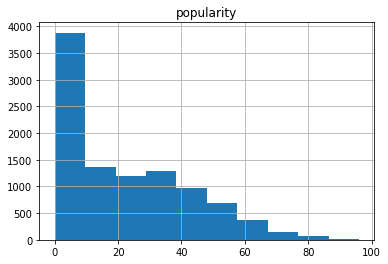

In [3]:
import matplotlib as plt
all_data.hist(column='popularity')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11afea990>]],
      dtype=object)

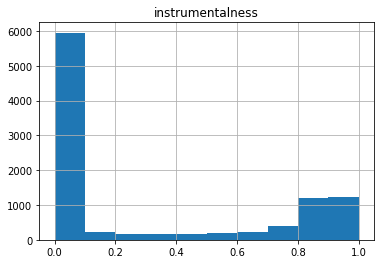

In [7]:
all_data.hist(column='instrumentalness')

In [10]:
all_data.loc[(all_data['popularity']>75) & (all_data['instrumentalness']>.6)]

,Unnamed: 0,track,artist,id,search term,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity,release date,artist popularity
6476,6642,Ribs,Lorde,0TEekvXTomKt3hdXDZxxeW,her,0.511,0.472,4.0,-9.277,1.0,0.091,0.534,0.614,0.11,0.0399,127.978,258969.0,76,2013-01-01,[81]


In [ ]:
# ribs by lorde has 172,931,889 plays and a popularity score of 76
# 34+35 has a popularity score of 92 but only 79,617,010 plays

In [13]:
all_data[all_data['artist']=='The Beatles']

,Unnamed: 0,track,artist,id,search term,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity,release date,artist popularity
105,112,Maxwell's Silver Hammer - Anthology 3 Version,The Beatles,5YHukxDZURFdM8agHmGCTl,maxwell,0.798,0.374,2.0,-10.090,1.0,0.0746,0.761000,0.001550,0.3690,0.784,128.973,229827.0,27,1996-10-28,[89]
1089,1131,Sgt. Pepper's Lonely Hearts Club Band - Remast...,The Beatles,4fUKE8EULjQdHF4zb0M8FO,pepper,0.451,0.673,7.0,-9.115,1.0,0.0734,0.085700,0.002250,0.7970,0.583,95.513,122893.0,64,1967-06-01,[89]
1489,1538,Back In The U.S.S.R,The Beatles,5rJjib4hv7JD1fpf5TzRcr,ussr,0.533,0.937,2.0,-7.510,1.0,0.0397,0.001730,0.000103,0.1850,0.862,142.399,154393.0,39,2006-11-17,[89]
2459,2548,Only A Northern Song,The Beatles,2upaZFZApLrvmkBzBFFS9m,submarine,0.364,0.723,6.0,-7.378,0.0,0.0506,0.000409,0.000192,0.0859,0.780,106.807,204507.0,37,2014-01-01,[89]
3417,3532,Back In The U.S.S.R. - Remastered 2009,The Beatles,0j3p1p06deJ7f9xmJ9yG22,fab,0.480,0.969,9.0,-7.464,1.0,0.0854,0.069000,0.000220,0.0608,0.494,142.489,163453.0,67,1968-11-22,[89]
5426,5585,Here Comes The Sun - Remastered 2009,The Beatles,6dGnYIeXmHdcikdzNNDMm2,two,0.557,0.540,9.0,-10.484,1.0,0.0347,0.033900,0.002480,0.1790,0.394,129.171,185733.0,82,1969-09-26,[89]
6605,6771,She Loves You - Remastered 2009,The Beatles,48JM82SHQTBYkhEYhMaOaa,masters,0.391,0.883,7.0,-5.973,1.0,0.0442,0.264000,0.000000,0.1570,0.927,75.442,141333.0,47,1988-03-07,[89]
8200,8380,Eleanor Rigby - Remastered 2009,The Beatles,5GjPQ0eI7AgmOnADn1EO6Q,beat,0.581,0.280,4.0,-9.091,0.0,0.0381,0.936000,0.000016,0.3050,0.813,137.831,126533.0,69,1966-08-05,[89]


In [ ]:
# classic hits that have been remastered look like they're dilluted too. there are 3 versions of elanor rigby
# on spotify, and their listens aren't aggregated. here you can see back in the USSR remastered and the original 
# release split popularity

In [30]:
missed = all_data[all_data['artist popularity']=='[]']
missed.reset_index(inplace=True)
missed.head()

,index,track,artist,id,search term,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity,release date,artist popularity
0,183,Bodily Horizon,Pranayama Flutes,4v52fU6A6qJWQvJSuKQ39G,bodily,0.164,0.100,1.0,-23.488,1.0,0.0463,0.990000,0.980000,0.108,0.03720,80.683,149284.0,0,2017-05-28,[]
1,184,Aster Argos - Remastered,Nibiru,74JQgOTYDrLeUUCxoWdOjb,argos,0.139,0.858,4.0,-6.427,1.0,0.1820,0.000036,0.079500,0.105,0.03820,148.676,768488.0,0,2013-02-22,[]
2,185,Struggle,FireBoss The General,34n6lw0TnfIdrFnqwEM6dB,general,0.793,0.572,7.0,-8.786,1.0,0.3220,0.198000,0.000000,0.113,0.87600,139.936,188212.0,34,2020-08-27,[]
3,186,stormy hill,"oh, the joy.",0st6S0yMSdcJRzjZadtDME,hi,0.056,0.925,3.0,-35.986,0.0,0.0689,0.994000,0.414000,0.900,0.00001,59.352,151742.0,66,2020-07-24,[]
4,187,Measurements,M. Curley,4uv4Kq8HPN6YSSalprfvfr,measurement,0.524,0.510,6.0,-7.843,0.0,0.0273,0.695000,0.000007,0.105,0.14700,117.345,293593.0,0,2015-03-15,[]


In [31]:
info, info_err = get_tracks_info(missed)

100%|██████████| 39/39 [00:03<00:00, 10.25it/s]


In [34]:
reformat = format_artist(info)

In [35]:
artist_pop, err_artist_pop = get_artist_info(reformat)
len(err_artist_pop)

40it [00:03, 10.29it/s]                        


0

In [78]:
replace = missed['id'].to_list()

def replace_vals(pop): 
    if pop == '[]':
        return 'NaN'
    else:
        return pop

def new_pop(song_id):
    if song_id in replace: 
        entry = missed.loc[missed['id']=='4v52fU6A6qJWQvJSuKQ39G']['artist popularity'].to_list()
        return entry[0]
    else:
        return 'NaN'

In [69]:
all_data['artist popularity'] = all_data['artist popularity'].apply(replace_vals)

In [81]:
all_data['second pop'] = all_data['id'].apply(replace_vals)

In [85]:
all_data.drop(columns = 'Unnamed: 0', inplace=True)

In [87]:
all_data['artist\'s popularity'] = all_data['artist popularity'].fillna(all_data['second pop'])

In [89]:
all_data['artist\'s popularity'][186]

'NaN'